In [2]:
import os 
import sys 
import cv2 
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import albumentations as at 
import matplotlib.pyplot as plt
import sklearn  
import random as py_random

In [3]:
from IPython.display import SVG 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.models import Model, Sequential, load_model 
from tensorflow.keras.optimizers import Adam, RMSprop, SGD 
from tensorflow.keras.utils import to_categorical, Sequence, model_to_dot 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping 
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Input, MaxPooling2D, GlobalAveragePooling2D, Conv2D, Concatenate

In [4]:

def set_seed_value(seed_value):
    tf.random.set_seed(seed_value)
    py_random.seed(seed_value)
    np.random.seed(seed_value)

def get_show_version():
    print(f"numpy : {np.__version__}")
    print(f"cv2 : {cv2.__version__}")
    print(f"pandas : {pd.__version__}")
    print(f"sklearn : {sklearn.__version__}")
    print(f"tensorflow : {tf.__version__}")
    print(f"python : {sys.version}")

def get_show_shape(images):
    for i in range(len(images)):
        print(f"shape {images[i].shape}")
    

def get_show_plot(images, labels, ncols):
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches = (12, 12)

    for i in range (ncols):
        ax=axes[i//5, i%5]
        ax.imshow(images[i], cmap="gray")
        ax.set_title(str(labels[i]))
    plt.tight_layout()
    plt.show()


In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
set_seed_value(2022)
get_show_version()
get_show_shape([train_images, train_labels, test_images, test_labels])

11501568/11490434 [==============================] - 0s 0us/step
numpy : 1.21.6
cv2 : 4.1.2
pandas : 1.3.5
sklearn : 1.0.2
tensorflow : 2.8.2
python : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
shape (60000, 28, 28)
shape (60000,)
shape (10000, 28, 28)
shape (10000,)


In [6]:
def get_preprocessed_images(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    return images, labels 

def get_preprocessed_one_hot_encoding(images, labels):
    images, labels, = get_preprocessed_images(images, labels)
    oh_labels = to_categorical(labels)

    return images, oh_labels 

def get_even_odd_separate(train_oh_labels, val_oh_labels, test_oh_labels): 
    tr_odd_labels = []
    val_odd_labels = []
    test_odd_labels = [] 

    for i in range(len(train_oh_labels)):
        if np.argmax(train_oh_labels[i]) % 2 == 0 : 
            tr_odd_labels.append(0)
        else: 
            tr_odd_labels.append(1)

    for i in range(len(val_oh_labels)):
        if np.argmax(val_oh_labels[i]) % 2 == 0 : 
            val_odd_labels.append(0)
        else: 
            val_odd_labels.append(1)

    for i in range(len(test_oh_labels)):
        if np.argmax(test_oh_labels[i]) % 2 == 0 : 
            test_odd_labels.append(0)
        else: 
            test_odd_labels.append(1)

    tr_odd_labels = np.array(tr_odd_labels)
    val_odd_labels = np.array(val_odd_labels)
    test_odd_labels = np.array(test_odd_labels)

    return tr_odd_labels, test_odd_labels, val_odd_labels 

def get_train_test_valid_separate(train_images, train_labels, test_images, test_labels):
    train_images, train_oh_labels = get_preprocessed_one_hot_encoding(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_one_hot_encoding(test_images, test_labels)

    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=0.2, random_state=2022)
    tr_odd_labels,  val_odd_labels, test_odd_labels, = get_even_odd_separate(tr_oh_labels, test_oh_labels, val_oh_labels)

    return (tr_images, tr_oh_labels, tr_odd_labels), (val_images, val_oh_labels, val_odd_labels), (test_images, test_oh_labels, test_odd_labels)

In [7]:
(tr_images, tr_oh_labels, tr_odd_labels), (val_images, val_oh_labels, val_odd_labels), (test_images, test_oh_labels, test_odd_labels) = get_train_test_valid_separate(train_images, train_labels, test_images, test_labels)
get_show_shape([tr_images, 
                tr_oh_labels, 
                tr_odd_labels, 
                val_images, 
                val_oh_labels, 
                val_odd_labels, 
                test_images, 
                test_oh_labels, 
                test_odd_labels])


shape (48000, 28, 28)
shape (48000, 10)
shape (48000,)
shape (12000, 28, 28)
shape (12000, 10)
shape (12000,)
shape (10000, 28, 28)
shape (10000, 10)
shape (10000,)


In [8]:
IMAGE_SIZE = 28 
EPOCHS = 20 

In [1]:
def set_create_model():
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="inputs")
    x = Conv2D(filters=32, kernel_size=(3,3))(input_tensor)
    x = Activation("relu")(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten(name = "flatten_layer")(x)

    flat_x = Flatten()(input_tensor)
    con_x = Concatenate()([x, flat_x])
    digit_output = Dense(10, activation="softmax", name="digit_output")(con_x)
    flat_x = Dense(32, activation="relu")(flat_x)
    odd_output = Dense(1, activation="sigmoid", name="odd_output")(flat_x)
    model = Model(inputs = input_tensor, outputs= [digit_output, odd_output])
    model.summary()

    return model 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 26, 26, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['activation[0][0]']             
                                                                                              

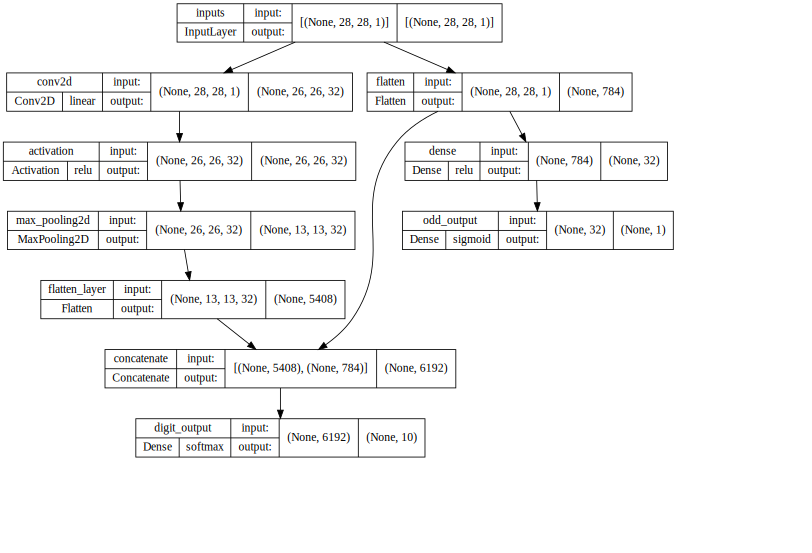

In [9]:
model = set_create_model()
SVG(model_to_dot(model, show_shapes=True, show_layer_activations=True, dpi=60).create(prog="dot", format="svg"))

In [10]:
model.compile(optimizer=Adam(lr=0.001), 
              loss={"digit_output":"categorical_crossentropy", 
                    "odd_output":"binary_crossentropy"},
              loss_weights={"digit_output":1, 
                           "odd_output":0.5},
              metrics = ["accuracy"])

history = model.fit({'inputs': tr_images}, 
                    {'digit_output': tr_oh_labels, 
                     'odd_output': tr_odd_labels}, 
                    validation_data=({'inputs': val_images},  
                                     {'digit_output': val_oh_labels, 'odd_output': val_odd_labels}), 
                    epochs=20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1500/1500 [==============================] - 19s 4ms/step - loss: 0.3175 - digit_output_loss: 0.2350 - odd_output_loss: 0.1650 - digit_output_accuracy: 0.9328 - odd_output_accuracy: 0.9389 - val_loss: 0.1608 - val_digit_output_loss: 0.1085 - val_odd_output_loss: 0.1047 - val_digit_output_accuracy: 0.9709 - val_odd_output_accuracy: 0.9638
Epoch 2/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1291 - digit_output_loss: 0.0860 - odd_output_loss: 0.0861 - digit_output_accuracy: 0.9754 - odd_output_accuracy: 0.9706 - val_loss: 0.1280 - val_digit_output_loss: 0.0895 - val_odd_output_loss: 0.0770 - val_digit_output_accuracy: 0.9743 - val_odd_output_accuracy: 0.9730
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0961 - digit_output_loss: 0.0634 - odd_output_loss: 0.0654 - digit_output_accuracy: 0.9808 - odd_output_accuracy: 0.9777 - val_loss: 0.1096 - val_digit_output_loss: 0.0765 - val_odd_output_loss: 0.0663 - val_digit_output_

In [11]:
model.evaluate({'inputs': test_images}, {'digit_output': test_oh_labels, 'odd_output': test_odd_labels})

313/313 [==============================] - 2s 4ms/step - loss: 0.1227 - digit_output_loss: 0.0847 - odd_output_loss: 0.0760 - digit_output_accuracy: 0.9815 - odd_output_accuracy: 0.9814


[0.12271726131439209,
 0.08469578623771667,
 0.07604290544986725,
 0.9815000295639038,
 0.9814000129699707]

#### Transfer Learning 

In [12]:
base_model_output = model.get_layer("flatten_layer").output

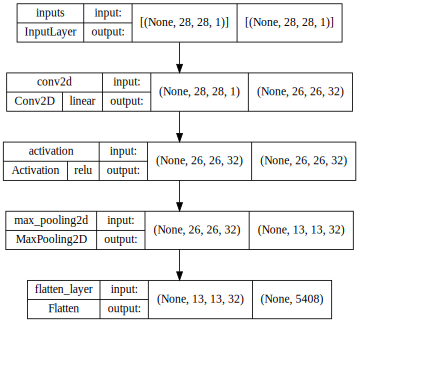

In [13]:
base_model = Model(inputs=model.input, outputs=base_model_output, name="base")
SVG(model_to_dot(base_model, show_shapes=True, show_layer_activations=True, dpi=60).create(prog="dot", format="svg"))

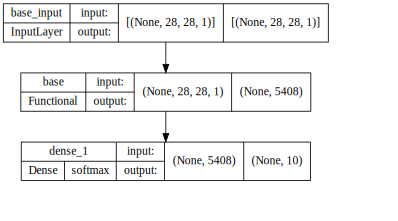

In [14]:
digit_model = Sequential([base_model, 
                          Dense(10, activation="softmax")])
SVG(model_to_dot(digit_model, show_shapes=True, show_layer_activations=True, dpi=60).create(prog="dot", format="svg"))

In [17]:
digit_model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(tr_images, tr_oh_labels, 
                    validation_data=(val_images, val_oh_labels), 
                    epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1500/1500 [==============================] - 5s 3ms/step - loss: 0.9394 - accuracy: 0.8142 - val_loss: 0.4861 - val_accuracy: 0.9045
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3904 - accuracy: 0.9170 - val_loss: 0.3281 - val_accuracy: 0.9262
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2936 - accuracy: 0.9315 - val_loss: 0.2680 - val_accuracy: 0.9369
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2484 - accuracy: 0.9389 - val_loss: 0.2348 - val_accuracy: 0.9438
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2207 - accuracy: 0.9450 - val_loss: 0.2123 - val_accuracy: 0.9492
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2012 - accuracy: 0.9490 - val_loss: 0.1963 - val_accuracy: 0.9528
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1865 - accuracy: 0.9524 - val_loss: 0.1836 - val_accuracy: 0.9557
Epo

#### Freeze Model 

In [18]:
base_model_frozen = Model(inputs =model.input, outputs=base_model_output, name="base_frozen")
base_model_frozen.trainable= False 
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________

In [22]:

dense_output = Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

digit_model_frozen.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = digit_model_frozen.fit(tr_images, 
                                tr_oh_labels,
                                validation_data=(val_images, val_oh_labels),
                                epochs=10)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1500/1500 [==============================] - 4s 3ms/step - loss: 0.1419 - accuracy: 0.9592 - val_loss: 0.0749 - val_accuracy: 0.9787
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0638 - accuracy: 0.9808 - val_loss: 0.0765 - val_accuracy: 0.9778
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0729 - val_accuracy: 0.9804
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0413 - accuracy: 0.9878 - val_loss: 0.0753 - val_accuracy: 0.9793
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0776 - val_accuracy: 0.9797
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0734 - val_accuracy: 0.9802
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.0804 - val_accuracy: 0.9798
Epo